# Processing and Writing Radiant ML Data to CSV

## Setup

Create the libraries + import config

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from utils.file_ops import *
from utils.data_prep import *
from utils.data_prep_geospatial import *

# get config
CONFIG = read_yaml('../../conf.yaml')

Setting up vars from config

In [4]:
data_dir = '../../data/'

Full_bands = CONFIG['BANDS']
collection_id = CONFIG['COLLECTION_ID']
assets = CONFIG['ASSETS']
processed_collection_id = CONFIG['PROCESSED_COLLECTION_ID']

crops = [c['id'] for c in CONFIG['CROPS']]
crops_names = [c['name'] for c in CONFIG['CROPS']]

selected_bands = [b['id'] for b in CONFIG['BANDS']]
source_collection = f'{collection_id}_source'
train_label_collection = f'{collection_id}_labels_train'
test_label_collection = f'{collection_id}_labels_test'

src_tile_size = (CONFIG['SRC_TILE_WIDTH'], CONFIG['SRC_TILE_HEIGHT'])

## Per-Field Image Tiles

We know from the codebook, that fields data may be spread between multiple tiles. Here, we will merge tiles where necessary, process the results, and recreate masked and scaled images for each field.

### Creating Merged tiles

We can confirm the presence of fields that cross over multiple tiles using the following code.

In [5]:
train_data = pd.read_csv(f'{data_dir}/pixel_data_TRAIN.csv', index_col=[0])


In [27]:
tmp_train_df = (
    train_data.drop_duplicates(
        subset = ['field_id', 'folder_id'],
        keep = 'last'
    )
    .groupby(by=['field_id'])
    .size()
    .value_counts()
    .rename_axis('tiles')
    .reset_index(name="fields")
)

tmp_train_df

,tiles,fields
0,1,5285
1,2,264
2,3,1
3,4,1


Looking at the above, we see the majority of fields contain data that is restricted to one tile. However, 266 fields are spread between 2-4 tiles. To handle this, we will crop and rescale our satellite images such that we end up with one contiguous image per band for each field.

Our first step is to merge relevant tiles and create a merge map in the process.

In [ ]:

merge_map = get_df_from_csv_if_exists(
    f'{data_dir}interstitial_data/merge_map.csv',
    lambda: create_merged_tiles(
        train_data,
        collection_id, 
        processed_collection_id, 
        train_label_collection, 
        source_collection, 
        selected_bands,
        'merged_TRAIN_v2'
    )
)

write_csv_from_df(merge_map, f'{data_dir}interstitial_data/merge_map')

print(merge_map.shape)
print(merge_map.head())

### Creating Masked and Scaled Images

Now, we will extract valid row/col positional data for each pixel using the newly joined merge files. 


In [13]:
row_col_data = get_df_from_csv_if_exists(
    f'{data_dir}interstitial_data/valid_row_col_vals_TRAIN_v2.csv',
    lambda: rol_col_extractor(
        merge_map, 
        'merged_TRAIN_v2', 
        processed_collection_id, 
        ['field_ids']
    )
)

write_csv_from_df(row_col_data, f'{data_dir}interstitial_data/valid_row_col_vals_TRAIN_v2')

print(row_col_data.shape)
row_col_data.head()


the file interstitial_data/valid_row_col_vals_TRAIN_v2.csv already exists.
(188228, 5)


,field_id,lon,lat,row,col
11031,757,628235.0,3025485.0,43,23
11287,757,628235.0,3025475.0,44,23
11288,757,628245.0,3025475.0,44,24
11289,757,628255.0,3025475.0,44,25
11543,757,628235.0,3025465.0,45,23


Now we will merge this data with our `train_data` using the 'lon' and 'lat' columns. 

*Note: In theory we could use GDAL to do this automatically, which would greatly simplify this process. However, due to projection issues, we are using x/y coordinates to achieve this*

In [19]:
# merge em
merged_train_data = get_df_from_csv_if_exists(
    f'{data_dir}interstitial_data/pixel_data_valid_row_col_vals_TRAIN.csv',
    lambda: pixel_data_row_col_merger(
        train_data, 
        row_col_data
    )
)

write_csv_from_df(merged_train_data, f'{data_dir}interstitial_data/pixel_data_valid_row_col_vals_TRAIN')

print(merged_train_data.shape)
merged_train_data.head()

the file interstitial_data/pixel_data_valid_row_col_vals_TRAIN.csv already exists.
(188228, 19)


,Unnamed: 0,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,field_id,folder_id,lon,lat,row,col
0,11031,43,39,38,38,41,54,63,61,64,12,57,37,757,28852,628235.0,3025485.0,43,23
1,11287,43,39,38,38,42,57,67,63,72,12,63,42,757,28852,628235.0,3025475.0,44,23
2,11288,43,39,38,37,41,59,69,65,78,12,68,43,757,28852,628245.0,3025475.0,44,24
3,11289,43,38,37,36,41,59,69,64,78,12,68,43,757,28852,628255.0,3025475.0,44,25
4,11543,43,39,38,38,42,57,67,64,72,12,63,42,757,28852,628235.0,3025465.0,45,23


Great! We now have a fully merged data set with pixel values for each field + valid positional data. Next, we will create our masked and scaled image files for each field.

In [15]:
create_masked_and_scaled_field_files(
    merged_train_data, 
    merge_map, 
    processed_collection_id, 
    selected_bands, 
    1 # padding
)

100%|██████████| 1289/1289 [00:11<00:00, 111.71it/s]


### Checking our Work

Now, we'll check our work by selecting a random field id, and plotting it's orginal merge file + it's masked and scaled files. We'll do this for one band only.

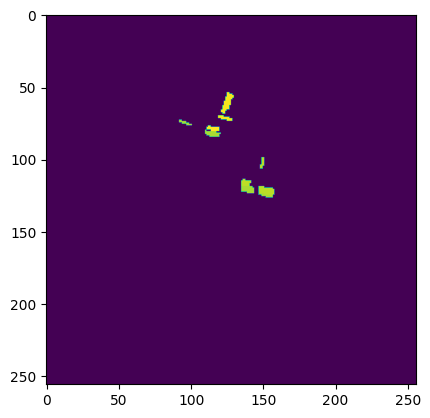

In [16]:
field_id = 7332
merge_id = merge_id = merge_map[merge_map['field_id'] == field_id]['merged_field_keys'].values[0]

scaled_img_path = f'{data_dir}ref_agrifieldnet_competition_v1_proc/merged_TRAIN_v2/merged_TRAIN_v2_{merge_id}/field_ids.tif'
floop_arr, _, src = read_geotiff(scaled_img_path)
plt.figure()
plt.imshow(floop_arr)
#close the src
src = None


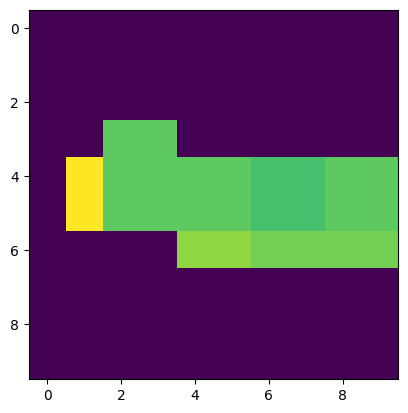

In [17]:
masked_img_path = f'{data_dir}ref_agrifieldnet_competition_v1_proc/masked_TRAIN/masked_TRAIN_{field_id}/B12.tif'
floop_arr, _, src = read_geotiff(masked_img_path)
plt.figure()
plt.imshow(floop_arr)
#close the src
src = None


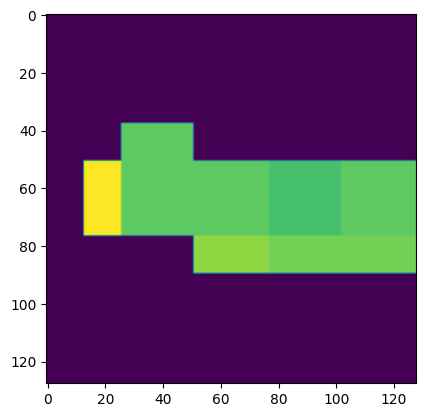

In [18]:
scaled_img_path = f'{data_dir}/scaled_TRAIN/scaled_TRAIN_{field_id}/B12.tif'
floop_arr, _, src = read_geotiff(scaled_img_path)
plt.figure()
plt.imshow(floop_arr)
#close the src
src = None